# Convolutional Neural Networks (CNN) and Deep Architectures

In these practicals, we will create a first convolutional neural network (CNN). This type of networks mostly rely on alternating layers of convolution and pooling. A convolution layer is a signal processing inspired layer that performs a bunch of convolutions on the layer input and yields filtered outputs known as feature maps. A pooling layer is a sort of subsampling layer. Most of the time, after several Conv/Pool layer pairs, a usual MLP is plugged to obtain class membership probabilities. When the number of layers is rather high (unclear how high this is), we obtain a deep network.

We will use `TensorFlow` as programming framework and build a CNN to solve an image classification task.

## Starting with TensorFlow

`TensorFlow` is Google's library designed to create and train deep nets. It relies on symbolic programming and on the notion of computation graph. Here is an example of such a graph:

<img src="graph.png" alt="drawing" width="200"/>

In this graph, we prepare `TensorFlow` to later compute the following function :

$$f\left( x,y\right) = x^2 + 2y,$$

for some $x$ and $y$. In this graph, the variables $x$ and $y$ are instances of the `tf.placeholder` class. Given these two objects, programming function $f$ is quite easy. We just need one line of code to explain `TensorFlow` how to compute $f\left( x,y\right)$ given $x$ and $y$:

```python
f = x*x + 2*y
```

This is done in a symbolic way meaning that $+$ here is not the usual Python + but `TensorFlow`'s addition operator. 

There are consequently two programming phases when using `TensorFlow`:
* graph building and variable declaration,
* actual computation performed as part of a `session`.

Here is the full code to build the graph for function $f$ followed by a `session` to compute function values for some $(x,y)$ pairs.

# Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

/home/cindy/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
import numpy as np
import sys
from matplotlib.pyplot import imshow
import gzip
import _pickle as cPickle


# Preliminary questions

In [4]:
x = tf.placeholder(tf.float32,shape=[])
y = tf.placeholder(tf.float32,shape=[])
f = x*x + 2*y
some_x = [1,2,3]
some_y = [2,3,4]
with tf.Session() as sess:
    for i in range(len(some_x)):
        print(sess.run(f,feed_dict={x: some_x[i],y: some_y[i]}))

5.0
10.0
17.0


The `tf.placeholder` class is meant to define variables that will be later replaced with data streams. Here, we specified that these data are `float32` and that they are scalars (`shape=[]`). In the `session`, we explain `TensorFlow` that the `x` and `y` will now be replaced by some specific values which we defined before as integer lists. 

### Q1
* Define in a symbolic way the gradient of function $f$ (see `TensorFlow.gradients` documentation) and compute the gradient vectors for the same $(x,y)$ pairs as in the above code. 


In [5]:
gradf_x_y = tf.gradients(ys= x*x+2*y, xs = [x,y])

with tf.Session() as sess:
    for i in range(len(some_x)):
        print(sess.run(gradf_x_y, feed_dict={x:some_x[i],y:some_y[i]}))


[2.0, 2.0]
[4.0, 2.0]
[6.0, 2.0]


In [6]:
a = tf.constant(0.)
b = 2 * a
g = tf.gradients(a + b, [a, b], stop_gradients=[a, b])
g[0]

<tf.Tensor 'gradients_1/Fill:0' shape=() dtype=float32>

# CNN 

---

## Baseline CNN

We are now almost ready to start building a `TensorFlow` graph containing convolution or pooling layers instead of the basic operations involved in function $f$. Unlike function $f$, the classification function that we are trying to learn is parametric. Parameters can be explicitely defined as `TensorFlow` variables which are instances of the `tf.Variable` class. Since the backpropagation cannot work if parameters are not intialized, we will be using an initializer provided by `TensorFlow`. However, we will not explicitely define parameters but instead use `TensorFlow` macroscopic layerwise functions which encompass `TensorFlow` variables. This makes the code much simpler but less modular.

But first things first ! We need a dataset to work with and to load in Jupyter. We will be working with the `MNIST` dataset. This dataset contains 28x28 grayscale images of handwritten figures. It has the advantage to be larger than traditional datasets utilized in practicals while it can still hold in memory and converge in a few minutes. Larger or more complicated datasets (more variability in images) would require too many computational efforts.

Download the `MNIST` archive at [mnist.pkl.gz](http://deeplearning.net/data/mnist/mnist.pkl.gz). Load the dataset using the `load_mnist` function. You need to feed it with the path to the `MNIST` archive.

## Load and preprocess data

In [7]:
# Load data
def load_mnist(filename):
    f = gzip.open(filename, 'rb')
    train_set, valid_set, test_set = cPickle.load(f, encoding='iso-8859-1')
    f.close()
    X = np.vstack((train_set[0],valid_set[0]))
    y = np.hstack((train_set[1],valid_set[1]))
    X_test = test_set[0]
    y_test = test_set[1]
    return X,y,X_test,y_test

# MISSING CODE
X,y,X_test,y_test = load_mnist( 'mnist.pkl.gz')
#
N_train = X.shape[0]
N_test = X_test.shape[0]

print(X.shape)
print(y.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


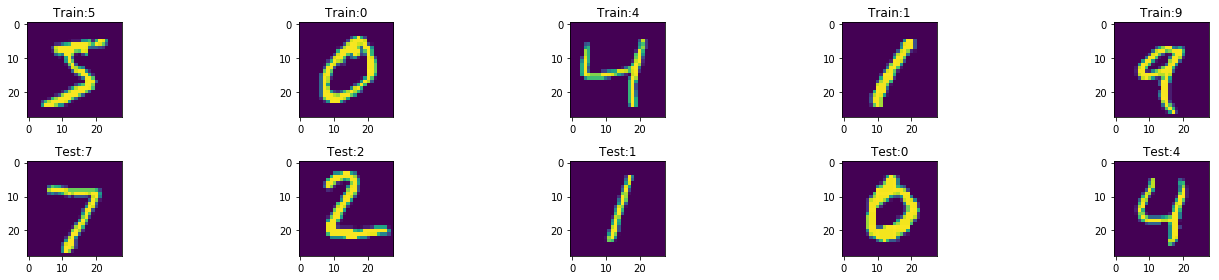

In [8]:
#show some images
plt.subplots(figsize = (20,4))
n_ex = 5
for i in range (n_ex):
    plt.subplot(2,n_ex,i+1)
    plt.imshow(X[i].reshape((28,28,)))
    plt.title("Train:"+str(y[i]))
    
    plt.subplot(2,n_ex,n_ex+i+1)
    plt.imshow(X_test[i].reshape((28,28,)))
    plt.title("Test:"+str(y_test[i]))
plt.tight_layout()

In [9]:
#MISSING CODE
#Reshape 
X = X.reshape((N_train,28,28,1))
X_test = X_test.reshape(N_test,28,28,1)


In [10]:
def normalize (x_train,x_norm):
    """ 
    Function to normalize the data
    params:
    - x_train : to compute the mean and standard deviation
    - x_norm : the data to be normalized
    return :
    - x_norm : the data normalized  
    """
    x_norm = (x_norm - x_train.mean(axis=0))/x_train.std(axis=0)
    return x_norm

X_train_norm = normalize(X,X)
X_test_norm = normalize(X,X_test)

/home/cindy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/home/cindy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


### Q2
* Reshape `X` and `X_test` so that they have shape (60000,28,28,1) and (10000,28,28,1) respectively.


We can now begin to build the CNN. At the start of the `TensorFlow` graph we need to define data containers, i.e. instances of `tf.placeholder`. We will use mini-batch gradient descent to optimize the NN parameters and we want the code to be modular so we cannot specify the first dimension of the tensor containing training examples. `TensorFlow` allows this :

In [9]:
Xtf = tf.placeholder(tf.float32,shape=[None, X.shape[1], X.shape[2],1])
ytf = tf.placeholder(tf.int64,shape=[None, ])

The next element of our NN is a 2D convolutional layer. We can use an instance of the `tf.layers.conv2d` class. We need to specify that a `tf.placeholder` instance is the input, the number of size of filters (kernels) that we want, how to deal with image borders (padding) and what activation we would like. This gives:

In [10]:
# Convolutional Layer #1
conv1 = tf.layers.conv2d(
      inputs=Xtf,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

Next, we need a pooling layer to give up some entries of the filtered images provided by the convolutional layer. We will use the usual max pool function in 2x2 neighborhoods which drops 3 entries out of 4 in each such neighborhood. The remaining entry is the one achieving maximal value in the neighborhood.

In [11]:
# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)


## Q3
* What is the role of parameter `strides` ? 
* What is the size of each feature map after max pooling ?
* How many feature maps are there ?

We will now plug a 1 layer MLP on top of this. Fully connected layers (or dense layers) do not accept `numpy ndarrays`. We can use `tf.reshape` to flatten feature maps. In the following code the scalar `dflat` = nbr of feature maps x feature map width x feature map height. Set this variable with the correct value and execute the following code line: 

- stride : is the number of step we take to slide the filter
- The output of the conv2d layer is size (28,28), as the padding is "same" and the stride is 1. After maxpooling of stride 2, we divide the number of pixels by 4. So the size of each feature map after max pooling is (14,14)
- There are 64 filters so 64 feature maps.

In [12]:
dflat = 64*14*14# MISSING CODE
pool2_flat = tf.reshape(pool1, [-1, dflat])
#pool2_flat = tf.layers.Flatten()(pool1)

Now the one layer MLP is given by an instance of `tf.layers.dense` as:

In [13]:
mlp = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)


Finally, we need a softmax regression function to obtain class membership probabilities. This can be done in this way:

In [14]:
logits = tf.layers.dense(inputs=mlp, units=10)
smax = tf.nn.softmax(logits)

### Q4
* How many parameters is there in our NN ?

Actually, the utimate element of the `TensorFlow` graph is the loss. In softmax (or logistic) regression, the corresponding loss is the cross entropy. A numerically stable version of this loss is given by `tf.losses.sparse_softmax_cross_entropy`:

Number of parameters: 
- Conv: 64 filters. Each filter is size 5x5. Each filter has a bias => parameters of filters = 64(5*5+1)
- 1st dense layer: has for input a vector of size dflat. units = 1024, adding the bias we obtain => dflat*1024+1024
- 2nd dense layer: 1024*10+10

In [15]:
number_of_parameters = 64*(5*5+1) + dflat*1024+1024 + 1024*10+10
print("Number of parameters:",number_of_parameters)

Number of parameters: 12857994


In [16]:
loss = tf.losses.sparse_softmax_cross_entropy(labels=ytf, logits=logits)

Now that we have completed the graph, we can move to the next phase: actually training the NN. Prior to entering the training loop, we need to instantiate an optimizer from `TensorFlow` and ask him to minimize the loss. We will use the ADAM optimizer which is robust and easy to tune.

In [17]:
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [18]:
pred = tf.argmax(logits,1)
equal = tf.equal(pred,ytf)
accuracy = tf.reduce_mean(tf.cast(equal,tf.float32))

An initializer has also been instantiated. Indeed parameters are hidden in instances of our NN layers but they need initialization anyway.

We can now begin to iterate on training examples. We will select mini-batches of training examples. Once each training example has been processed as part of the backpropagation algorithm, a training epoch is completed. It is quite common to iterate on epochs, and in each epoch on mini-batches. 

The following code lines are in line with this habit. There are only two lines to complete to make it work. They correpond to the selection of training examples in each mini-batch. 


### Q5
* Fulfill correctly the missing parts of these instructions.
**Warning** : the execution of the loop takes around 5mn. The gradient descent should achieve approximately a 0.13 loss or below (remember this is stochastic).

In [19]:
n_epochs = 1
batch_size = 300
loss_history=[]
saver = tf.train.Saver()

X = X_train_norm[:1000]
X_test = X_test_norm
y=y[:1000]
N_train = X.shape[0]

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = N_train // batch_size
        
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = X[iteration*batch_size :(iteration+1)*batch_size  ] # MISSING CODE
            y_batch = y[iteration*batch_size :(iteration+1)*batch_size  ] # MISSING CODE
            
            #Update parameters by computing gradient of loss
            sess.run(training_op, feed_dict={Xtf: X_batch,ytf: y_batch})
            loss_history.append(loss.eval(feed_dict={Xtf: X_batch,ytf: y_batch}))
        
        #Compute loss
        loss_train = loss.eval(feed_dict={Xtf: X_batch,ytf: y_batch})
        print("\n Accuracy test:", sess.run(accuracy,feed_dict={Xtf: X_test,ytf: y_test}))
        print("\r{}".format(epoch), "Train loss:", loss_train)

    saver.save(sess, '/home/cindy/Documents/Scolaire/DAD/ML/TP6_tensorflow/my-model')

    


66%
 Accuracy test: 0.3113
0 Train loss: 2.7464156


In [37]:
with tf.Session() as sess:
    saver.restore(sess,'/home/cindy/Documents/Scolaire/DAD/ML/TP6_tensorflow/my-model')
    print("\n Accuracy test:", sess.run(accuracy,feed_dict={Xtf: X_test,ytf: y_test}))

INFO:tensorflow:Restoring parameters from /home/cindy/Documents/Scolaire/DAD/ML/TP6_tensorflow/my-model

 Accuracy test: 0.3954


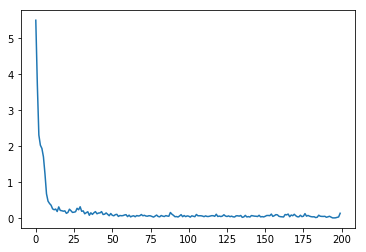

In [28]:
nb_history = len(loss_history)
plt.plot(np.arange(nb_history),loss_history)

### Q6
* Document yourselves on means to compute the classifier accuracy using `TensorFlow` functions. 
* Add the corresponding functions to the graph.
* Modify the loop to evaluate the classifier accuracy on the test set. 
* Comment on the quality of the learning.
** Accuracy on test set is very good TOODOOOOO**

## Q7 Add a second pair of conv/pool layers.
* A smaller amount of filters and smaller filters are recommended.

In [66]:
# Convolutional Layer #1
conv1 = tf.layers.conv2d(
      inputs=Xtf,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

In [67]:
# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)


In [68]:
# Convolutional Layer #2
conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=32,
      kernel_size=[3,3],
      padding="same",
      activation=tf.nn.relu)

In [69]:
# Pooling Layer #1
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

#dflat = 64*14*14# MISSING CODE
#pool2_flat = tf.reshape(pool2, [-1, dflat])
pool2_flat = tf.layers.Flatten()(pool2)

In [70]:
mlp = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)


In [71]:
logits = tf.layers.dense(inputs=mlp, units=10)
smax = tf.nn.softmax(logits)

In [72]:
loss = tf.losses.sparse_softmax_cross_entropy(labels=ytf, logits=logits)

Now that we have completed the graph, we can move to the next phase: actually training the NN. Prior to entering the training loop, we need to instantiate an optimizer from `TensorFlow` and ask him to minimize the loss. We will use the ADAM optimizer which is robust and easy to tune.

In [73]:
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [74]:
pred = tf.argmax(logits,1)
equal = tf.equal(pred,ytf)
accuracy = tf.reduce_mean(tf.cast(equal,tf.float32))

In [80]:
n_epochs = 1
batch_size = 300
loss_history=[]
saver = tf.train.Saver()


N_train = X.shape[0]

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = N_train // batch_size
        
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = X[iteration*batch_size :(iteration+1)*batch_size  ] # MISSING CODE
            y_batch = y[iteration*batch_size :(iteration+1)*batch_size  ] # MISSING CODE
            
            #Update parameters by computing gradient of loss
            sess.run(training_op, feed_dict={Xtf: X_batch,ytf: y_batch})
            loss_history.append(loss.eval(feed_dict={Xtf: X_batch,ytf: y_batch}))
        
        #Compute loss
        loss_train = loss.eval(feed_dict={Xtf: X_batch,ytf: y_batch})
        print("\n Accuracy test:", sess.run(accuracy,feed_dict={Xtf: X_test,ytf: y_test}))
        print("\r{}".format(epoch), "Train loss:", loss_train)

    saver.save(sess, '/home/cindy/Documents/Scolaire/DAD/ML/TP6_tensorflow/my-model_conv2')

    


99%
 Accuracy test: 0.9797
0 Train loss: 0.14407563


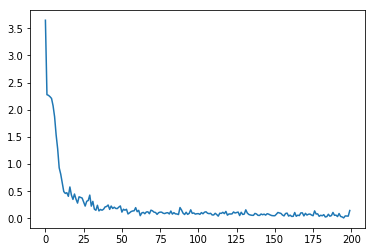

In [81]:
plt.plot(np.arange(len(loss_history)),loss_history)

## Q8 Add a second fully connected layer. 
* A smaller number of units is recommended.

In [82]:
# Convolutional Layer #1
conv1 = tf.layers.conv2d(
      inputs=Xtf,
      filters=64,
      kernel_size=[5, 5],
      padding="same",
      activation=tf.nn.relu)

In [83]:
# Pooling Layer #1
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)


In [84]:
# Convolutional Layer #2
conv2 = tf.layers.conv2d(
      inputs=pool1,
      filters=32,
      kernel_size=[3,3],
      padding="same",
      activation=tf.nn.relu)

In [85]:
# Pooling Layer #1
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

#dflat = 64*14*14# MISSING CODE
#pool2_flat = tf.reshape(pool2, [-1, dflat])
pool2_flat = tf.layers.Flatten()(pool2)

In [86]:
mlp = tf.layers.dense(inputs=pool2_flat, units=1024, activation=tf.nn.relu)


In [87]:
mlp2 = tf.layers.dense(inputs=mlp, units=512, activation=tf.nn.relu)


In [88]:
logits = tf.layers.dense(inputs=mlp2, units=10)
smax = tf.nn.softmax(logits)

In [89]:
loss = tf.losses.sparse_softmax_cross_entropy(labels=ytf, logits=logits)

Now that we have completed the graph, we can move to the next phase: actually training the NN. Prior to entering the training loop, we need to instantiate an optimizer from `TensorFlow` and ask him to minimize the loss. We will use the ADAM optimizer which is robust and easy to tune.

In [90]:
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()

In [91]:
pred = tf.argmax(logits,1)
equal = tf.equal(pred,ytf)
accuracy = tf.reduce_mean(tf.cast(equal,tf.float32))

In [ ]:
n_epochs = 1
batch_size = 300
loss_history=[]
saver = tf.train.Saver()


N_train = X.shape[0]

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = N_train // batch_size
        
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="")
            sys.stdout.flush()
            X_batch = X[iteration*batch_size :(iteration+1)*batch_size  ] # MISSING CODE
            y_batch = y[iteration*batch_size :(iteration+1)*batch_size  ] # MISSING CODE
            
            #Update parameters by computing gradient of loss
            sess.run(training_op, feed_dict={Xtf: X_batch,ytf: y_batch})
            loss_history.append(loss.eval(feed_dict={Xtf: X_batch,ytf: y_batch}))
        
        #Compute loss
        loss_train = loss.eval(feed_dict={Xtf: X_batch,ytf: y_batch})
        print("\n Accuracy test:", sess.run(accuracy,feed_dict={Xtf: X_test,ytf: y_test}))
        print("\r{}".format(epoch), "Train loss:", loss_train)

    saver.save(sess, '/home/cindy/Documents/Scolaire/DAD/ML/TP6_tensorflow/my-model_conv2')

    


45%

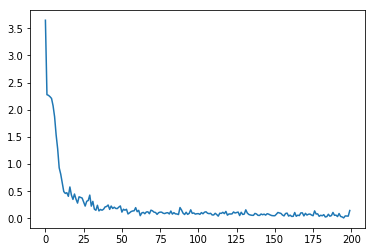

In [81]:
plt.plot(np.arange(len(loss_history)),loss_history)

## Q9 try to tweak the other hyperparameters. 
 These latter include:
* the learning rate,
* the mini batch size,
* the regularization strength (if regularization is activated),
* number of filters,
* filter sizes,
* activiation functions,
* strides,
* padding types,
* ...


## Q10
* Compare the obtained accuracy to that of a regularized Softmax regression from `sklearn`.

In [34]:
dicto = {1:"eo",2:3}

In [41]:
a = dicto.__getitem__

In [42]:
print(a)

<built-in method __getitem__ of dict object at 0x7f378c0e6828>


In [43]:
dicto.layer_size = 10

AttributeError: 'dict' object has no attribute 'layer_size'

In [49]:
class AttrDict(dict):
    __getattr__ = dict.__getitem__


TypeError: dict expected at most 1 arguments, got 3